<img src="../../images/BikeDNA_logo.svg" width="250"  alt="BikeDNA logo" style="display:block; margin-left: auto; margin-right: auto;">
<a href="https://github.com/anerv/BikeDNA">Github</a>

# 2a. Initialize reference data

This notebook:
- Loads the polygon defining the study area and then creates a grid overlay for the study area.
- Loads the reference data.
- Processes the reference data to create the network structure and attributes needed in the analysis.

<div class="alert alert-block alert-info">
<b>Prerequisites &amp; Input/Output</b>
<p>
<span style="font-family:courier;">config.yml</span> must be set in advance.
    
Output files of this notebook are saved to the <span style="font-family:courier;">../data/REFERENCE/[study_area]/processed/</span> subfolder and used in notebooks 2b, 3a and 3b.

When the network is created from the reference data, each edge is assigned a unique edge ID. To relate the edge ID back to the ID in the original data, the dataframes with network edges, <span style="font-family:courier;">ref_edges</span> and <span style="font-family:courier;">ref_edges_simplified</span>, can be used.
</p>
</div>

**Sections**
* [Load data for study area and create analysis grid](#Load-data-for-study-area-and-create-analysis-grid)
* [Load and preprocess reference data](#Load-and-preprocess-reference-data)

<br />

## Load data for study area and create analysis grid

This step:

- Loads settings for the analysis from the configuration file `config.yml`.
- Reads data for the study area.
- Creates a grid overlay of the study area, with grid cell size defined in `config.yml`.

<div class="alert alert-block alert-warning">
<b>Troubleshooting</b>
<p>
If in the cell below the functions located in the <i>src</i> folder do not load properly: Check that <span style="font-family:courier;">pip install -e .</span> was run successfully (see instructions in <span style="font-family:courier;">README.md</span>).
</p>
</div>

In [1]:
# Load libraries, settings and data

import pickle
import warnings

import contextily as cx
# import os
# os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np

from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import simplification_functions as simp_func
from src import plotting_functions as plot_func

%run ../settings/plotting.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

warnings.filterwarnings("ignore")

/opt/miniconda3/envs/bikedna_dk/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data for study area

The study area is defined by the user-provided polygon. It will be used for the computation of **global** results, i.e. quality metrics based on all data in the study area.

In [2]:
# Read polygon for study area

study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print("Please assign a crs to the study area polygon!")

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f"The size of the study area is {area / 1000000:.2f} km2.")

The size of the study area is 43056.58 km2.


This study area will be used for the analysis:


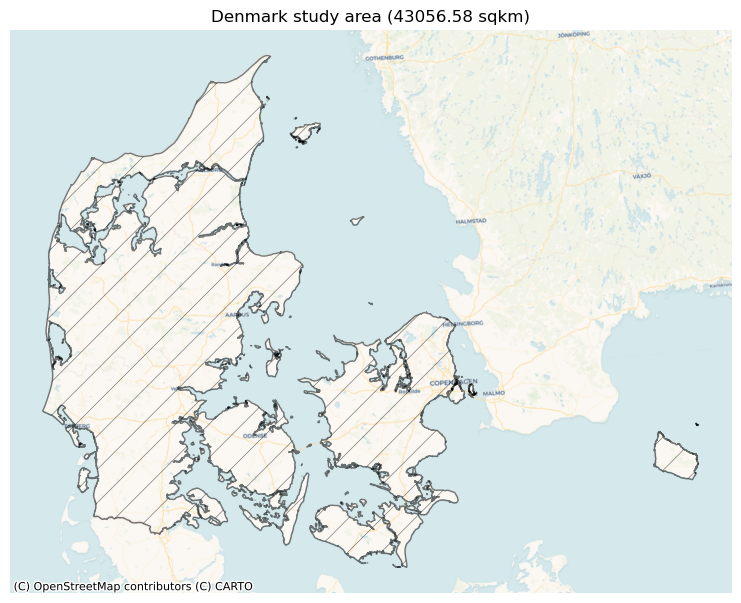

In [3]:
# Plot study area

set_renderer(renderer_map)
print("This study area will be used for the analysis:")

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
    
study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor='none',alpha=pdict["alpha_back"],hatch='/')

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(f"{area_name} study area ({area / 1000000:.2f} sqkm)")

plot_func.save_fig(fig, ref_results_static_maps_fp + "area_size_reference")

### Create analysis grid

<div class="alert alert-block alert-info">
<b>User configurations</b>
<p>
The grid is used to compute <b>local</b> results for many of the quality metrics, i.e. on grid cell level. The cell size of the grid cells must be specified in the configuration file. Smaller grid cells will increase the computation time but give a more granular result. The grid cell size should not be smaller than the scale at which you would expect actual differences in data quality.
</p>
</div>

Creating hexagons at resolution 8...
The grid contains 78175 hex cells with an average area of 0.59 km2.
This grid will be used for local (grid cell level) analysis:


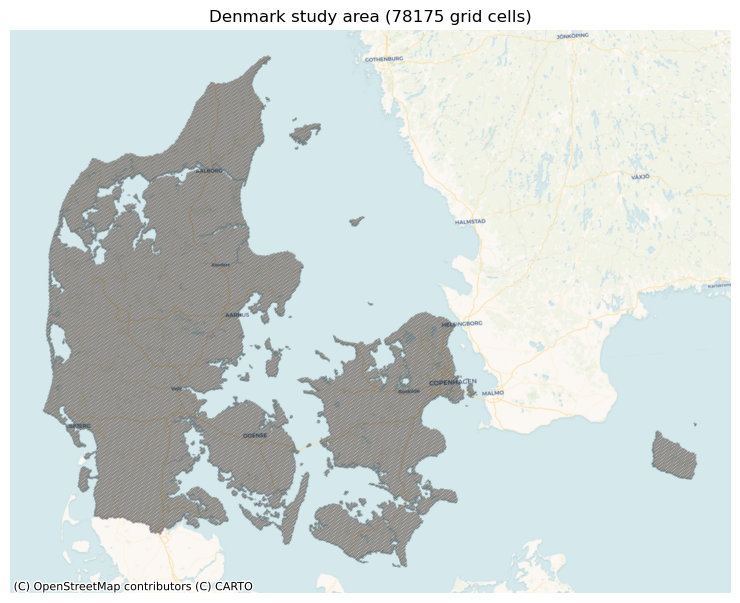

In [4]:
# Create and plot grid

set_renderer(renderer_map)

grid = eval_func.create_h3_grid(study_area_poly, 8, study_crs, 500)

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
grid_cell_area = grid.area.mean() / 1000000 # in km2
print(f"The grid contains {len(grid)} hex cells with an average area of {grid_cell_area:.2f} km2.")
print("This grid will be used for local (grid cell level) analysis:")
grid.plot(ax=ax, facecolor="none", edgecolor=pdict["base"], alpha=pdict["alpha_back"],linewidth=0.2)
ax.set_axis_off()
cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)
ax.set_title(
    f"{area_name} study area ({len(grid)} grid cells)"
)

plot_func.save_fig(fig, ref_results_static_maps_fp + "area_grid_osm")

## Load and preprocess reference data

This step:

- Creates a network from the reference data.
- Projects it to the chosen CRS.
- Clips the data to the polygon defining the study area.
- Measures the infrastructure length of the edges based on the geometry type and whether they allow for bidirectional travel or not.
- Simplifies the network.
- Creates copies of all edge and node data sets indexed by their intersecting grid cell.

**Network data model**

In BikeDNA, all input data are converted to a network structure consisting of *nodes* and *edges*. Edges represents the actual infrastructure, such as bike lanes and paths, while nodes represents the start and end points for the edges, as well as all intersections. For further details, read more about the [network data model](https://networkx.org/documentation/stable/reference/introduction.html).


<details><summary><b>Network simplification</b></summary>

When converting a set of linestrings to network (graph) format, not all vertices (nodes) are of equal meaning. For the geometry of edges, all nodes are used to define the shape of the edge. For the topology of the network, however, only those nodes that are endpoints or intersection points with other edges are needed, while all other (so-called 'interstitial') nodes do not add any information. To compare the structure and true ratio between nodes and edges in a network, a simplified network representation which only includes nodes at endpoints and intersections, or where the value of important attributes changes, is required. An additional advantage of simplifying the network is the resulting substantial reduction of the number of nodes and edges, which makes computational routines much faster.

Note that the simplification function only simplifies and merges edges that have identical values for important attributes such as geometry type, bicycle direction, and protection level. 

<p align="center">
<img src='../../images/network_simplification_illustration.png' width=300/>

*Non-simplified network (left) and simplified network (right)*

</p>

As part of the simplification routine, in cases where there are several edges between the same pair of nodes ('parallel edges' or 'multiedges'), only one of the edges is retained.

To read more about the modified OSMnx simplification [(Boeing, 2017)](https://geoffboeing.com/publications/osmnx-complex-street-networks/) used here, we refer to this [GitHub repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration.

</details>

In [5]:
# Read reference data
org_ref_data = gpd.read_parquet(reference_fp)

# Create data with LineStrings only defined by end and start coordinate
ref_data = graph_func.unzip_linestrings(org_ref_data, reference_id_col)

# Create column with id called 'osmid'
ref_data["osmid"] = ref_data["new_edge_id"]
ref_data.drop(["new_edge_id"], axis=1, inplace=True)

# Reproject
if ref_data.crs == None:
    print("Please assign a crs to the study area polygon!")

if ref_data.crs != study_crs:
    ref_data = ref_data.to_crs(study_crs)

assert ref_data.crs == study_crs

# Clip reference data to study area poly
# ref_data = ref_data.clip(study_area_poly)

# ref_data = ref_data[ref_data.geometry.length!=0.0]

# Convert to osmnx graph object
graph_ref = graph_func.create_osmnx_graph(ref_data)

ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

# Overview of data
graph_area = eval_func.get_graph_area(ref_nodes, study_area_poly, study_crs)
print(
    f"The {reference_name} data covers an area of {graph_area / 1000000:.2f} km2."
)
print("\n")

# Classify edges as protected or unprotected
ref_edges = eval_func.define_protected_unprotected(
    ref_edges, ref_bicycle_infrastructure_type
)
for key, value in ref_edges.protected.value_counts().items():
    perc = np.round(100*value/len(ref_edges),2)
    print(f"Edges where the protection level is '{key}': {value} out of {len(ref_edges)} ({perc}%)")
print("\n")

# Summarize attribute values - if there are columns with values for each row instead of a global setting
if bicycle_bidirectional in ref_edges.columns:
    for key, value in ref_edges.bicycle_bidirectional.value_counts().items():
        perc = np.round(100*value/len(ref_edges),2)
        print(f"Edges where 'bicycle_bidirectional' is {key}: {value} out of {len(ref_edges)} ({perc}%)")
else: 
    print("Using global settings for cycling direction.")
print("\n")

if reference_geometries in ref_edges.columns:
    for key, value in ref_edges.bicycle_geometries.value_counts().items():
        perc = np.round(100*value/len(ref_edges),2)
        print(f"Edges where the geometry type is '{key}': {value} out of {len(ref_edges)}({perc}%)")
else:
    print("Using global settings for geometry type.")
print("\n")

# Add attributes to graph
protected_dict = ref_edges["protected"].to_dict()
nx.set_edge_attributes(graph_ref, protected_dict, "protected")

# Add 'multiple edge' attribute to each edge of the graph
for e in graph_ref.edges:
    graph_ref.edges[e]["multiedge"] = 0

# Count multiple edges and store info at key 0
# (simplification routine keeps only key 0)
for u, v, k in graph_ref.edges:
    if k > 0:
        graph_ref.edges[u, v, 0]["multiedge"] += 1

# Remove geometry attribute (required by simplification function)
for n1, n2, d in graph_ref.edges(data=True):
    d.pop("geometry", None)

# Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of bicycle infrastructure types
graph_ref_simplified = simp_func.simplify_graph(
    graph_ref, attributes=["protected"], remove_rings=False
)

graph_ref = ox.get_undirected(graph_ref)
ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)
graph_ref_simplified = ox.get_undirected(graph_ref_simplified)

ref_nodes_simplified, ref_edges_simplified = ox.graph_to_gdfs(graph_ref_simplified)

ref_edges["length"] = ref_edges.geometry.length
ref_edges_simplified["length"] = ref_edges_simplified.geometry.length

# Measure the length of bicycle infrastructure (!=from length of edges)
if (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

else:
    print(
        f"Invalid data types for the variables reference_geometetries and/or bicycle_bidirectional!"
    )

print(
    f"The length of the {reference_name} network is {ref_edges_simplified.infrastructure_length.sum()/1000 :.2f} km."
)


# Creating coulumns with unique feature id (required by some functions)
ref_edges["edge_id"] = ref_edges.reset_index().index
ref_edges_simplified["edge_id"] = ref_edges_simplified.reset_index().index

ref_id_dict = ref_edges["edge_id"].to_dict()
nx.set_edge_attributes(graph_ref, ref_id_dict, "edge_id")

ref_id_dict_s = ref_edges_simplified["edge_id"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_id_dict_s, "edge_id")

# Saving data to graphs
ref_l_dict = ref_edges["length"].to_dict()
nx.set_edge_attributes(graph_ref, ref_l_dict, "length")

ref_l_dict_s = ref_edges_simplified["length"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_l_dict_s, "length")

ref_il_dict = ref_edges_simplified["infrastructure_length"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_il_dict, "infrastructure_length")

The GeoDanmark data covers an area of 42577.06 km2.


Edges where the protection level is 'protected': 358129 out of 664251 (53.91%)
Edges where the protection level is 'unprotected': 306122 out of 664251 (46.09%)


Using global settings for cycling direction.


Using global settings for geometry type.


The length of the GeoDanmark network is 8675.52 km.


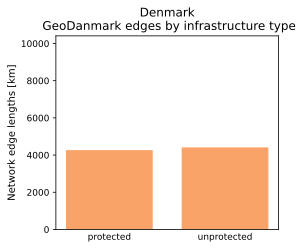

In [6]:
# Plot global statistics (by network length)

set_renderer(renderer_plot)
ymax = ref_edges.length.sum() * 1.2 /1000 # conversion m to km

# attribute: bidirectional
if bicycle_bidirectional in ref_edges.columns:
    
    x = []
    y = []

    for value in np.unique(ref_edges.bicycle_bidirectional):
        x.append(str(value))
        y.append(ref_edges[ref_edges["bicycle_bidirectional"]==value].length.sum()/1000) # conversion m to km

    plot_func.make_bar_plot(
        data = y,
        bar_labels = x,
        y_label = "Network edge lengths [km]",
        x_positions = [i for i in range(len(x))],
        title = f"{area_name}\n {reference_name} edges by bidirectionality",
        bar_colors = len(x)*[pdict["ref_base"]],
        filepath = ref_results_plots_fp + "edge_global_bidirectional",
        ylim = ymax,
        figsize=pdict["fsbar_small"]
    );

# attribute: protection
x = []
y = []

for value in np.unique(ref_edges.protected):
    x.append(value)
    y.append(ref_edges[ref_edges["protected"]==value].length.sum()/1000) # conversion m to km
    
plot_func.make_bar_plot(
    data = y,
    bar_labels = x,
    y_label = "Network edge lengths [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n {reference_name} edges by infrastructure type",
    bar_colors = len(x)*[pdict["ref_base"]],
    filepath = ref_results_plots_fp + "edge_global_infrastructuretype",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
);

# attribute: bicycle geometries (mapping type)
if reference_geometries in ref_edges.columns:

    x = []
    y = []

    for value in np.unique(ref_edges.bicycle_geometries):
        x.append(value)
        y.append(ref_edges[ref_edges["bicycle_geometries"]==value].length.sum()/1000) # conversion m to km

    plot_func.make_bar_plot(
        data = y,
        bar_labels = x,
        y_label = "Network edge lengths [km]",
        x_positions = [i for i in range(len(x))],
        title = f"{area_name}\n {reference_name} edges by mapping type",
        bar_colors = len(x)*[pdict["ref_base"]],
        filepath = ref_results_plots_fp + "edge_global_mappingtype",
        ylim = ymax,
        figsize=pdict["fsbar_small"]
    );

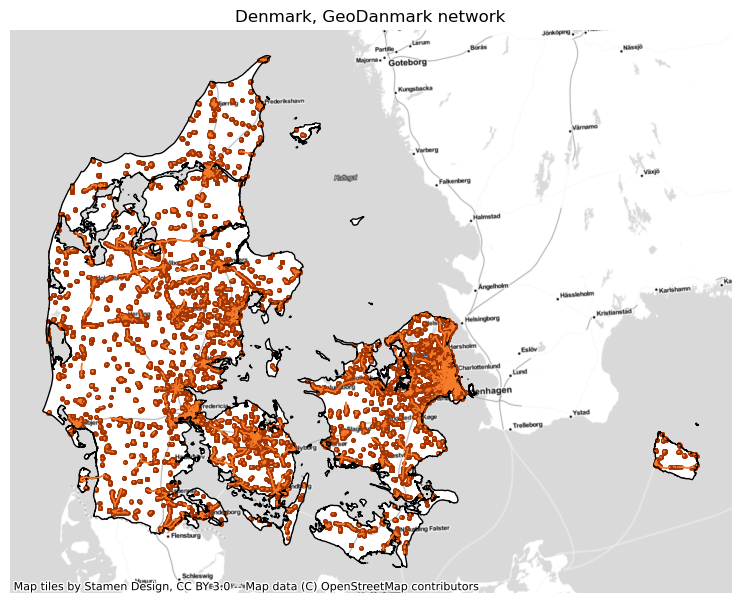

In [7]:
# Plot network

set_renderer(renderer_map)
fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

ref_edges_simplified.plot(ax=ax, color=pdict["ref_base"], linewidth=pdict["line_base"])
ref_nodes_simplified.plot(ax=ax, color=pdict["ref_emp"], markersize=pdict["mark_emp"])

study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor="None", linewidth=1)

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_2)

ax.set_title(f"{area_name}, {reference_name} network")

plot_func.save_fig(fig, ref_results_static_maps_fp + "area_network_reference")

In [8]:
# Joining grid cell id to network elements

ref_edges_simp_joined = gpd.overlay(
    ref_edges_simplified.reset_index(), grid, how="intersection", keep_geom_type=True
)
ref_edges_joined = gpd.overlay(
    ref_edges.reset_index(), grid, how="intersection", keep_geom_type=True
)

ref_nodes_simp_joined = gpd.overlay(
    ref_nodes_simplified.reset_index(), grid, how="intersection", keep_geom_type=True
)
ref_nodes_joined = gpd.overlay(
    ref_nodes.reset_index(), grid, how="intersection", keep_geom_type=True
)

# Count features in each grid cell
all_data_ref = [
    ref_edges_joined,
    ref_nodes_joined,
    ref_edges_simp_joined,
    ref_nodes_simp_joined,
]
labels_ref = ["ref_edges", "ref_nodes", "ref_simplified_edges", "ref_simplified_nodes"]

for data, label in zip(all_data_ref, labels_ref):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")


# Recomputing infrastructure length for data joined to grid
ref_edges_simp_joined["length"] = ref_edges_simp_joined["geometry"].length

if (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

else:
    print(
        f"Invalid data types for the variables reference_geometries and/or bicycle_bidirectional!"
    )

assert round(ref_edges_simplified.infrastructure_length.sum() / 1000, 1) == round(
    ref_edges_simp_joined.infrastructure_length.sum() / 1000, 1
)

In [9]:
# Save reference data
exec(open("../settings/save_refdata.py").read())

GeoDanmark nodes and edges saved successfully!
GeoDanmark networks saved successfully!
Reference grid saved successfully!


***

In [10]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))

Time of analysis: Mon, 22 May 2023 14:42:36
